In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from app.core import constants
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

In [2]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['figure.figsize'] = (8 * 0.75, 4.5 * 0.75)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.labelsize'] = 8
mpl.rcParams['font.size'] = 8

mpl.rcParams['savefig.transparent'] = True
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['savefig.bbox'] = 'tight'

In [3]:
identity = pd.read_csv(
    'data/dataset/train_identity.csv',
    dtype=constants.IDENTITY_COLUMN_TYPES
) # each id_XX column represents a property of the transaction identity

identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
transactions = pd.read_csv(
    'data/dataset/train_transaction.csv',
    dtype=constants.TRANSACTION_COLUMN_TYPES  # reduces ~50 % of the dataset memory size
)

transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,False,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,False,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,False,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,False,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,False,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
fraud_density = transactions['isFraud'].value_counts()

Text(0.5, 1.0, 'Distribution of transactions')

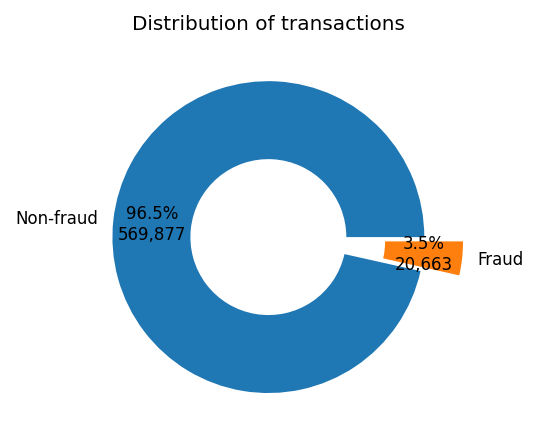

In [6]:
fig, ax = plt.subplots()

ax.pie(
    fraud_density, 
    autopct=lambda x: '{:.1f}%\n{:,.0f}'.format(x, x * sum(fraud_density) / 100),
    #textprops=dict(color="w"),
    explode=[0, 0.25],
    wedgeprops=dict(width=0.5),
    labels=['Non-fraud', 'Fraud'],
    pctdistance=0.75,
)

ax.set_title('Distribution of transactions')

In [7]:
from app.core.encoder import DateEncoder

In [8]:
date_data = pd.concat(
    [
        transactions['isFraud'],
        pd.DataFrame(
            DateEncoder().fit_transform(transactions['TransactionDT']),
            columns=DateEncoder().get_feature_names_out()
        )
    ],
    axis=1
)

Text(0.5, 0, 'Week')

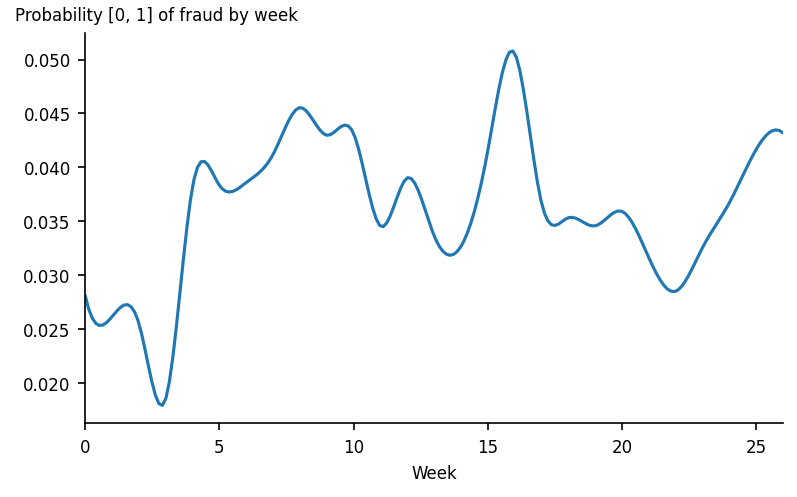

In [9]:
fig, ax = plt.subplots()

fraud_by_date = date_data.eval('week = day // 7').groupby('week')['isFraud'].mean()

spline = make_interp_spline(fraud_by_date.index, fraud_by_date)

# Returns evenly spaced numbers
# over a specified interval.
x_date = np.linspace(fraud_by_date.index.min(), fraud_by_date.index.max(), 200)
y_date = spline(x_date)

ax.plot(x_date, y_date)
ax.set_xlim(fraud_by_date.index.min(), fraud_by_date.index.max())

ax.set_ylabel('Probability [0, 1] of fraud by week', ha='left', y='1.025', rotation=0)
ax.set_xlabel('Week')

Text(0.5, 1.0, 'Probability [0, 1] of fraud\nby hour of the day')

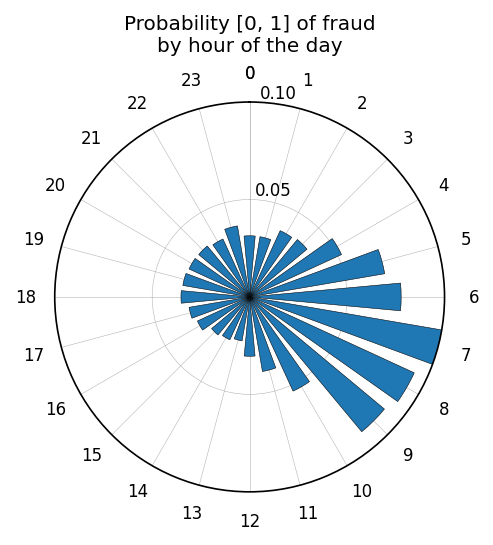

In [10]:
fraud_by_hour = date_data.astype(
    {
        'time': int
    }
).groupby('time')['isFraud'].mean()

ax = plt.subplot(projection='polar')

ax.bar(
    fraud_by_hour.index / 12 * np.pi,
    fraud_by_hour, 
    width=(2 * np.pi / 24) * 0.7, 
    bottom=0.0, 
    zorder=2,
    edgecolor='k',
    lw=0.25
)

ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2)

ax.set_rticks([0.05, 0.1])
ax.set_xticks(np.linspace(0, 1, 25) * 2 * np.pi)
ax.set_xticklabels(np.arange(0, 25) % 24)

ax.grid(
    zorder=0,
    lw=0.25
)

ax.set_rlabel_position(3)  # Move radial labels away from plotted line
ax.set_rlim(0, 0.1)

ax.set_title('Probability [0, 1] of fraud\nby hour of the day')

Text(0.5, 0, 'Day of week')

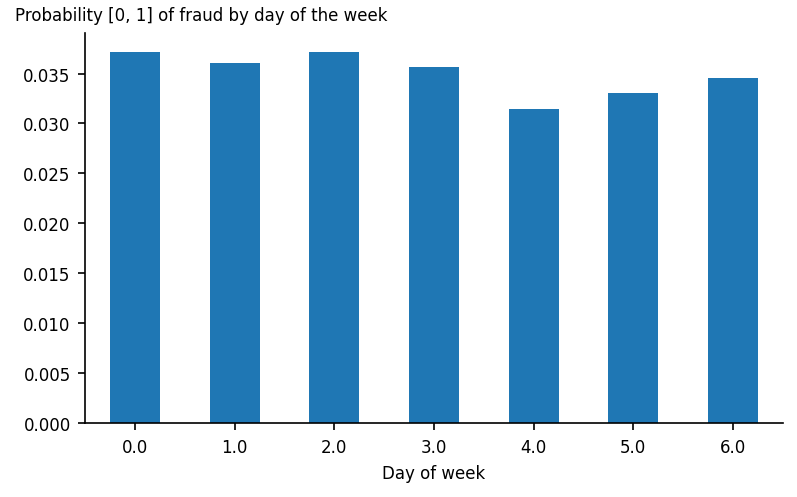

In [11]:
fig, ax = plt.subplots()

date_data.groupby('day_of_week')['isFraud'].mean().plot.bar(
    ax=ax
)

ax.tick_params(axis='x', labelrotation=0)
ax.set_ylabel('Probability [0, 1] of fraud by day of the week', ha='left', y='1.025', rotation=0)
ax.set_xlabel('Day of week')

In [12]:
def get_correlations(data):
    correlations = pd.concat(
        [
            data.select_dtypes(float),
            data.select_dtypes(int),
            data.select_dtypes(bool)
        ],
        axis=1
    ).drop(
        columns=['TransactionID'],
        errors='ignore'
    )

    melt = correlations.corr().reset_index().melt(
        id_vars='index'
    ).query(
        "index != variable"
    )
    
    melt['hash'] = melt.apply(
        lambda x: min(x['index'], x['variable']) + max(x['index'], x['variable']),
        axis=1
    )
    
    return melt.eval('abs = abs(value)').sort_values(
        'abs',
        ascending=False
    ).drop_duplicates(subset='hash').drop(
        columns=[
            'hash',
        ]
    ).rename(
        columns={
            'index': 'variable_1',
            'variable': 'variable_2'
        }
    )

# Build dataset

Merges identity information with transactions, then drops any duplicated transaction

In [13]:
dataset = identity.merge(
    transactions,
    on='TransactionID',
    how='right'
).drop_duplicates(
    subset=['TransactionID']
).set_index(
    'TransactionID'
)

dataset.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Correlation

In [14]:
print(f'Using {constants.CORRELATION_THRESHOLD} as the maximum correlation allowed between two features')

Using 0.75 as the maximum correlation allowed between two features


Finding the correlations with:
```
dataset_corr = get_correlations(dataset)
to_drop = dataset_corr.query(
    f"abs > {constants.CORRELATION_THRESHOLD}"
)

to_drop_columns = sorted(set(to_drop.loc[~to_drop['variable_1'].isin(to_drop['variable_2']), 'variable_1']))
print(to_drop_columns)
```

Columns to be dropped are:

In [15]:
print(constants.CORRELATED_FEATURES)

['C5', 'D15', 'D2', 'D5', 'V110', 'V113', 'V116', 'V117', 'V12', 'V120', 'V123', 'V140', 'V142', 'V147', 'V161', 'V173', 'V184', 'V188', 'V19', 'V198', 'V210', 'V223', 'V23', 'V238', 'V244', 'V25', 'V250', 'V262', 'V27', 'V272', 'V288', 'V290', 'V291', 'V3', 'V300', 'V325', 'V337', 'V36', 'V37', 'V45', 'V47', 'V5', 'V53', 'V6', 'V61', 'V67', 'V76', 'V77', 'V8', 'V83', 'V87', 'id_22']


## PCA

In order to reduce the dimensionality of the dataset a PCA is applied over the "VXXX" columns

In [16]:
import re
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [17]:
#constants.PCA_COLUMNS = [
#    col for col in dataset.columns if re.match(r'V\d+', col) and col not in constants.CORRELATED_FEATURES
#]

pca = PCA().fit(
    StandardScaler().fit_transform(
        SimpleImputer(
            fill_value=-1
        ).fit_transform(
            dataset[constants.PCA_COLUMNS]
        )
    )
)

Text(200, 60, 'Preserved 98 % of the variance\n with 40% of the columns')

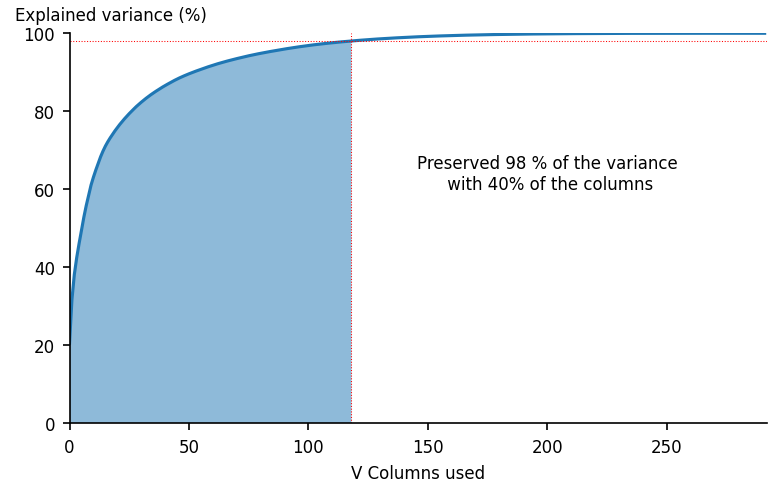

In [18]:
fig, ax = plt.subplots()

ax.plot(
    np.arange(len(constants.PCA_COLUMNS)),
    np.cumsum(pca.explained_variance_ratio_) * 100
)

ax.set_xlim(0, len(constants.PCA_COLUMNS))
ax.set_ylim(0, 100)

ax.set_xlabel('V Columns used')
ax.set_ylabel('Explained variance (%)', ha='left', y='1.025', rotation=0)

n_columns = sum(np.cumsum(pca.explained_variance_ratio_) <= 0.98)

ax.axhline(98, c='r', lw=0.5, ls=':')
ax.axvline(n_columns, c='r', lw=0.5, ls=':')

ax.fill_between(
    np.arange(n_columns + 1),
    np.cumsum(pca.explained_variance_ratio_)[:n_columns+1] * 100,
    alpha=0.5
)

ax.text(
    200,
    60,
    'Preserved 98 % of the variance\n with 40% of the columns',
    ha='center',
    
)

In [19]:
print(f'Compression rate: {n_columns / len(constants.PCA_COLUMNS):.2f}')

Compression rate: 0.40


## Model

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from app.core.encoder import FrequencyEncoder
from sklearn.preprocessing import OneHotEncoder

In [21]:
transformer = Pipeline(
    [
        (
            'column_splitter',
            ColumnTransformer(
                [
                    (
                        'pca',
                        Pipeline(
                            [
                                ('imputer', SimpleImputer(fill_value=-1)),  # defining the imputing technique is a case study on its own
                                ('standard_scaler', StandardScaler()),
                                ('pca', PCA(n_components=118))
                            ]
                        ),
                        constants.PCA_COLUMNS
                    ),
                    (
                        'frequency_encoded',
                        FrequencyEncoder(),
                        constants.FREQUENCY_ENCODER_COLUMNS
                    ),
                    (
                        'onehot_encoded',
                        OneHotEncoder(     
                            drop='first',
                            sparse_output=False,
                            handle_unknown='warn'
                        ),
                        constants.ONEHOT_ENCODER_COLUMNS
                    ),
                    (
                        'time_encoded',
                        DateEncoder(),
                        'TransactionDT'
                    )
                ],
                remainder='passthrough',
                force_int_remainder_cols=False,
                verbose_feature_names_out=False
            )
        ),
        (
            'impute',
            SimpleImputer(fill_value=-1)  # defining the imputing technique is a case study on its own
        )
    ]
)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    dataset.drop(
        columns=['isFraud'] + constants.CORRELATED_FEATURES
    ),
    dataset['isFraud'],
    random_state=1234
)

## Handle outliers

Detect outliers based on each column distribution using Turkey method. Keep entries with less than 15 outlier columns

In [28]:
def detect_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)

    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)

    outliers = ~data.apply(
        lambda x: (((x >= lower_bound) & (x <= upper_bound)) | x.isna() | (q1 == q3)),  # ignore nans and columns with sparse values
        axis=1
    )

    return outliers.sum(axis=1) >= int(data.shape[1] * 0.1)  # many columns increases the probability of an outlier (38 = 10 % of columns)

In [29]:
outliers = detect_outliers(x_train.select_dtypes(float))

x_train = x_train.loc[~outliers]
y_train = y_train.loc[~outliers]

## Train model

In [30]:
%%time

pipeline = Pipeline(
    [
        ('transformer', transformer),
        (
            'classifier', 
            RandomForestClassifier(
                n_estimators=100,
                n_jobs=-2,
                random_state=1234
            )
            #GradientBoostingClassifier(
            #    n_estimators=50,
            #    random_state=1234
            #)
        )
    ]
)

pipeline.fit(
    x_train,
    y_train
)

CPU times: user 36min 26s, sys: 3.55 s, total: 36min 29s
Wall time: 5min 40s


Pipeline(steps=[('transformer',
                 Pipeline(steps=[('column_splitter',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    remainder='passthrough',
                                                    transformers=[('pca',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(fill_value=-1)),
                                                                                   ('standard_scaler',
                                                                                    StandardScaler()),
                                                                                   ('pca',
                                                                                    PCA(n_components=118))]),
                                                                   ['V1', 'V2',
                                                                    'V4', 'V7',
                                                                    'V9', 'V10',
                                                                    'V11',
                                                                    'V13',
                                                                    'V14',
                                                                    'V15',
                                                                    'V16',
                                                                    'V...
                                                                    'card6',
                                                                    'M1', 'M2',
                                                                    'M3', 'M4',
                                                                    'M5', 'M6',
                                                                    'M7', 'M8',
                                                                    'M9',
                                                                    'id_12',
                                                                    'id_15',
                                                                    'id_16',
                                                                    'id_23',
                                                                    'id_27',
                                                                    'id_28',
                                                                    'id_29',
                                                                    'id_34',
                                                                    'id_35',
                                                                    'id_36',
                                                                    'id_37',
                                                                    'id_38',
                                                                    'DeviceType']),
                                                                  ('time_encoded',
                                                                   DateEncoder(),
                                                                   'TransactionDT')],
                                                    verbose_feature_names_out=False)),
                                 ('impute', SimpleImputer(fill_value=-1))])),
                ('classifier',
                 RandomForestClassifier(n_jobs=-2, random_state=1234))])

## Validate

In [31]:
yy_pred = pipeline.predict_proba(x_test)[:, 1]

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, yy_pred, pos_label=1)

Text(0.5, 1.0, 'ROC AUC: 0.917')

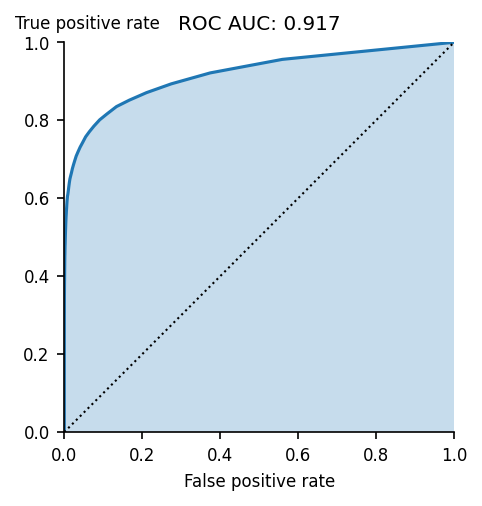

In [33]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], c='k', lw=1, ls=':')

ax.fill_between(fpr, tpr, alpha=0.25)

ax.set_aspect('equal')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate', ha='left', y='1.025', rotation=0)

ax.set_title(
    f'ROC AUC: {roc_auc_score(y_test, yy_pred):.3f}'
)

Text(71.58333333333334, 0.5, 'Observed')

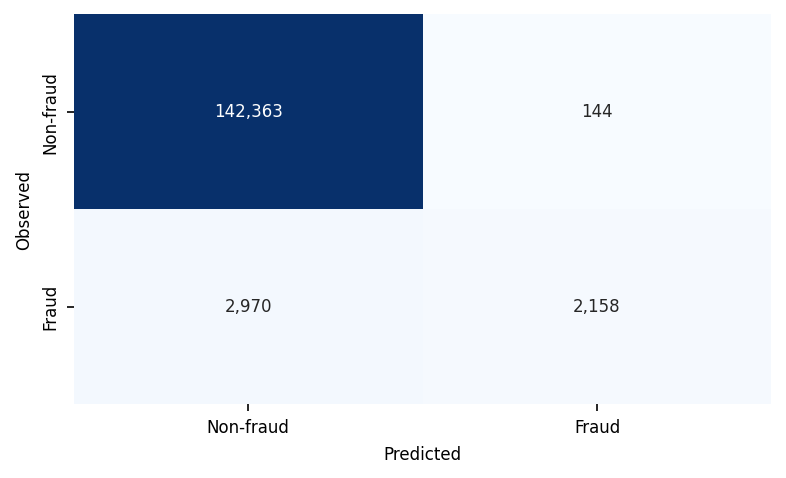

In [34]:
fig, ax = plt.subplots()

sns.heatmap(
    pd.DataFrame(
        confusion_matrix(y_test, yy_pred >= 0.5),
        index=['Non-fraud', 'Fraud'],
        columns=['Non-fraud', 'Fraud'],
    ),
    annot=True,
    fmt=",",
    cmap='Blues',
    cbar=False,
    ax=ax
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')

## Get feature importances

In [35]:
importances = pd.DataFrame(
    {
        'value': pipeline['classifier'].feature_importances_,
        'category': [
            'Other' if col not in ('time', 'day', 'day_of_month', 'day_of_week') else 'Time'
            for col in pipeline[0].get_feature_names_out()
        ]
    },
    index=[
        col.title().replace('Pca', 'PCA').replace('_', ' ')
        for col in pipeline[0].get_feature_names_out()
    ]
).sort_values('value', ascending=False)

importances = importances.reset_index().pivot_table(
    index='index',
    columns='category',
    values='value'
).loc[
    importances.index
]

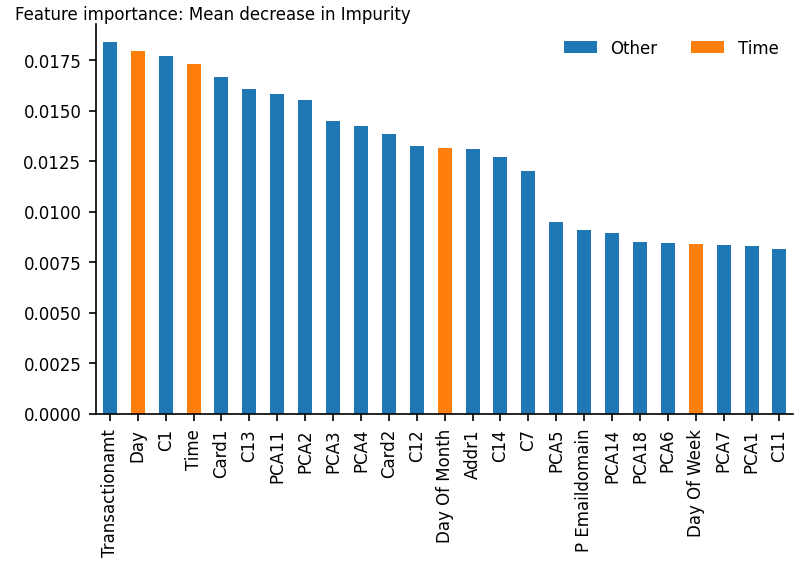

In [36]:
fig, ax = plt.subplots()

importances.iloc[:25].plot.bar(
    ax=ax,
    legend=False,
    width=0.5,
    stacked=True
)

ax.set_ylabel(
    'Feature importance: Mean decrease in Impurity',
    ha='left', y='1.0', 
    rotation=0
)

ax.legend(
    frameon=False,
    ncols=2
)

- Most relevant features come from the `transactions` dataset.
- Time proves to be very important, as all of the time related features are in the upper 10 % of the feature importance.
- `C` and `V` (encoded as PCA) columns also show high relevance in classifying fraud.

# Persist model

In [40]:
import gzip
import pickle

In [41]:
with gzip.open("app/assets/model.gz", "wb") as file:
    pickle.dump(pipeline, file)